# Preprocessing of density data for Python Colormap Tutorial

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import fiona
from shapely.geometry import Polygon, MultiPolygon, shape
from descartes.patch import PolygonPatch
from scipy.stats import gaussian_kde
from scipy.ndimage.filters import convolve
from scipy.sparse import coo_matrix, save_npz

%matplotlib inline

#BOUNDS = [53.5, 7, 58.2 ,14]
BOUNDS = [57, 10, 58 ,11]


## Requirements
To run this notebook, you will first have to download and uncompress the file `dk_csv_feb2017.rar` from here:
https://www.soefartsstyrelsen.dk/SikkerhedTilSoes/Sejladsinformation/AIS

## Preprocessing location data

In [2]:
df = pd.read_csv('data/aisdk_20170205.csv',
                 usecols=['Latitude','Longitude','Name'],
                 engine='c')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10532204 entries, 0 to 10532203
Data columns (total 3 columns):
Latitude     float64
Longitude    float64
Name         object
dtypes: float64(2), object(1)
memory usage: 241.1+ MB


In [4]:
df_sub = df[df.Latitude.between(BOUNDS[0],BOUNDS[2]) & df.Longitude.between(BOUNDS[1],BOUNDS[3])].copy()
df_sub_sample = df_sub.sample(200000)


In [5]:
figsize = np.array([BOUNDS[3]-BOUNDS[1], BOUNDS[2]-BOUNDS[0]])*3

values = np.zeros(figsize*300)
df_sub['xbin'] = ((df_sub['Longitude'] - BOUNDS[1]) / (BOUNDS[3] - BOUNDS[1]) * (values.shape[0] - 1)).astype(int)
df_sub['ybin'] = ((df_sub['Latitude'] - BOUNDS[0]) / (BOUNDS[2] - BOUNDS[0]) * (values.shape[1] - 1)).astype(int)
df_coords = df_sub.groupby(['xbin', 'ybin']).agg({'Name':'count'}).astype(int).reset_index()


for i, row in df_coords.iterrows():
    values[row['xbin'],row['ybin']] = row['Name']

In [6]:
# create a convolution filter
xx, yy = np.meshgrid(range(-20,21),range(-20,21))
filter = np.exp(-(yy**2 + xx**2)/1.5**2)

# remove some outliers and convolve
convolved = convolve(values.clip(0, 500), filter)

# save the file
save_npz('sample_data/density.npz', coo_matrix(convolved, dtype=np.float16))

### Preview the data
To preview the data, you'll have to download the denmark shapefile from here:
https://gadm.org/download_country_v3.html

(10, 11)

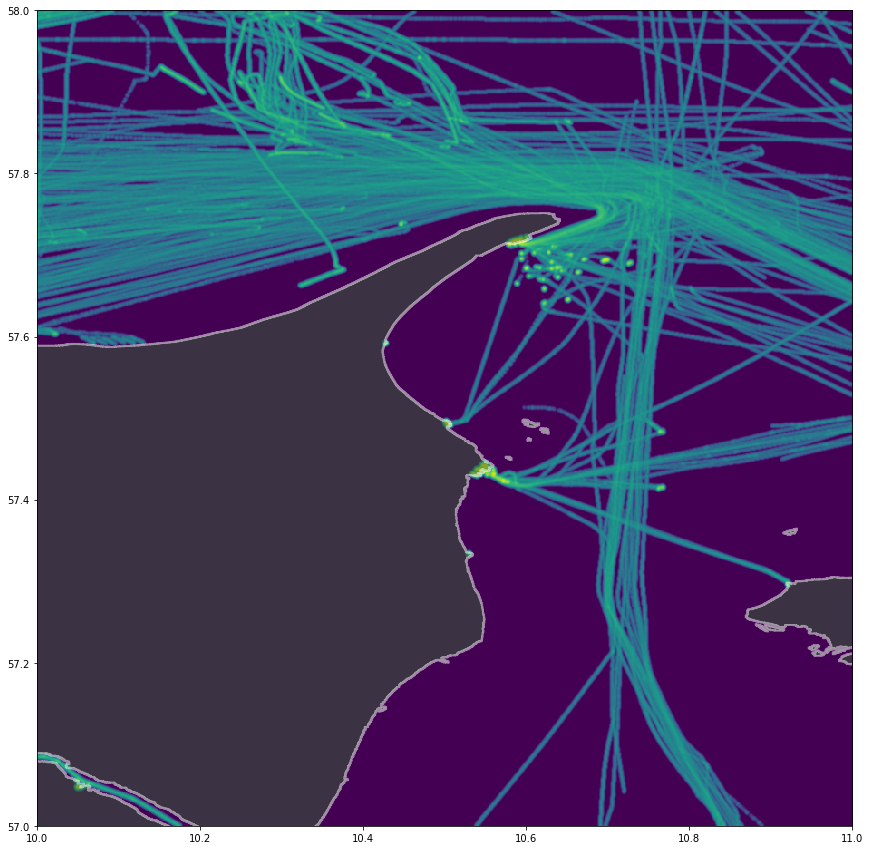

In [7]:

shapefile2 = fiona.open('data/gadm36_DNK_shp/gadm36_DNK_0.shp')

values_temp = convolved.copy()
values_temp = np.log(values_temp * 10 + 1)
plt.figure(figsize=(15, 15))
plt.imshow(values_temp.transpose(), 
           origin='lower', 
           extent=(BOUNDS[1], BOUNDS[3], BOUNDS[0], BOUNDS[2]))


ax=plt.gca()

for country in shapefile2:
    p = shape(country['geometry'])
    patch = PolygonPatch(p,
                         fill=True,
                         alpha=.5,
                         edgecolor='#FFFFFF',
                         lw=2,
                         facecolor='#336633')

    ax.add_patch(patch)


plt.ylim(BOUNDS[0],BOUNDS[2])
plt.xlim(BOUNDS[1],BOUNDS[3])

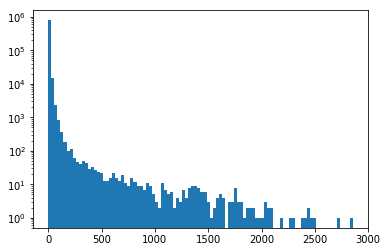

In [8]:
fig = plt.hist(convolved.flatten(),bins=100,log=True)